In [1]:
import sys, time

In [2]:
sys.path.append('..')

In [3]:
import matplotlib
import matplotlib.pyplot as plt

import torch

import numpy as np
import pandas as pd

import gym

import autotrain
import autotrain.gym_env 
import autotrain.agent.replay_memory as replay_memory

# if gpu is to be used
DEVICE = torch.device("cuda:3")

In [4]:
# agent import
import random
import math
from itertools import count
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import autotrain.agent.dqn as dqn
import autotrain.agent.replay_memory as replay_memory

from tqdm.notebook import tqdm

# Agent Definitions

In [5]:
class DQN_MLP(nn.Module):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inputs, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, outputs),
            nn.Softmax(),
        )

    def forward(self, x):
        return self.net(x)

In [6]:
BATCH_SIZE = 16
GAMMA = 0.999

EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

TARGET_UPDATE = 20 



class AutoTrainAgent: 

    def __init__(self, env, device):
        
        self.env = env
        self.device = device

        self.observation_dim = env.observation_space_dim
        
        # Get number of actions from gym action space
        self.n_actions = env.action_space_dim

        self.policy_net = dqn.DQN_MLP(self.observation_dim, self.n_actions).to(device)
        self.target_net = dqn.DQN_MLP(self.observation_dim, self.n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.RMSprop(self.policy_net.parameters())
        self.memory = replay_memory.ReplayMemory(10_000)

        self.steps_done = 0


    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * self.steps_done / EPS_DECAY)
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                
                if len(state.shape) == 1:
                    state = state.view(1, -1)
                print(f'[ATA] state dimensions: ', state.shape)
                actions = self.policy_net(state)
                
                return actions.max(-1)[1].view(-1, 1)
        else:
            print('[ATA] exploration policy enacted')
            return torch.tensor([[random.randrange(self.n_actions)]], device=self.device, dtype=torch.long)
        
        
    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = replay_memory.Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.stack([s for s in batch.next_state
                                                    if s is not None])

        state_batch = torch.stack(batch.state)
        action_batch = torch.cat(batch.action).view(BATCH_SIZE, 1)
        reward_batch = torch.cat(batch.reward)
        print(f'[ATA] batch shapes: [{state_batch.shape} {action_batch.shape} {reward_batch.shape}]')

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(BATCH_SIZE, device=self.device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        print('[ATA] DQN optimisation step complete ')
        
    def _preproc_state(self, state):
        return torch.FloatTensor(np.concatenate(state, axis=0)).to(self.device)
        
    def episode(self, i_episode):
        # Initialize the environment and state
        global RL_PROGRESS_PATH

        state = self._preproc_state(self.env.reset())

        for t in count():
            start_time = time.time()
            
            # Select and perform an action
            action = self.select_action(state)
            next_state, reward, done, _ = self.env.step(action.item())
            next_state = self._preproc_state(next_state) if not done else next_state  # for MLP, only one dim
            
            reward = torch.FloatTensor([reward]).to(self.device)

            # Store the transition in memory
            self.memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the target network)
            self.optimize_model()
            print(f'[ATA episode {i_episode}]: took [{time.time() - start_time:.1f}] seconds for one full step')
            if done:
                break
                
        self.steps_done += 1

        # Update the target network, copying all weights and biases in DQN
        if i_episode % TARGET_UPDATE == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            
        print(f'[ATA] replay buffer length: [{len(self.memory)}]')
        savepath = RL_PROGRESS_PATH / f'{i_episode}_episode'
        savepath.mkdir()
        
        env.save_env(savepath)
        torch.save(self.policy_net.state_dict(), savepath / 'policy_net.ckpt')
        torch.save(self.target_net.state_dict(), savepath / 'target_net.ckpt')
        self.memory.save(savepath / 'replay_buffer.pkl')

        return t
            

# Environment

## Classifier Data Prep - MNIST

In [7]:
# !rm -rf ./results/full_min_proto_0/*

In [8]:
DATA_ROOT = Path('../data')
DATA_SPLIT = 0.6

ENV_PATH = Path('./results/autotrain-run')
ENV_PATH.mkdir(exist_ok=True)

RL_PROGRESS_PATH = Path('./results/') 
RL_PROGRESS_PATH.mkdir(exist_ok=True)
RL_PROGRESS_PATH /= 'full_min_proto_1_phi_changes'
RL_PROGRESS_PATH.mkdir(exist_ok=True)

In [9]:
if any(RL_PROGRESS_PATH.iterdir()):
    print('[WARNING!!]: save dir is not empty; agent will not save if folder exists')

In [10]:
CLASSES = range(10)

def reduceds(ds, pct_cap, no_signal=False):
    X, Y = ds.data, ds.targets
    
    if pct_cap:
        cap = int(pct_cap*len(X))
        X, Y = X[:cap], Y[:cap]
        
    
    if no_signal:
        print('suffling labels')
        np.random.shuffle(Y)
    
    ds.data, ds.targets = X, Y

def get_dataset(tfms, no_signal=False, pct_cap=None):
    train = torchvision.datasets.MNIST(root=DATA_ROOT / 'mnist-data', train=True,
                                        download=True, transform=tfms)

    holdout = torchvision.datasets.MNIST(root=DATA_ROOT / 'mnist-data', train=False,
                                           download=True, transform=tfms)
        
    # train.data, train.targets = train.data.numpy(),train.targets.numpy()
    # holdout.data, holdout.targets = holdout.data.numpy(),  holdout.targets.numpy()
    
    reduceds(train, pct_cap, no_signal)
    
    print(f'length of trainset: [{len(train)}]; len of holdout: [{len(holdout)}]')
    
    return train, holdout

In [11]:
# make ds
# pytorch datasets
# n_train = n_holdout

In [12]:
TFMS = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

train, holdout = get_dataset(TFMS, pct_cap=0.2)

length of trainset: [12000]; len of holdout: [10000]


In [13]:
def accuracy(data: torch.utils.data.DataLoader, model: nn.Module): # phi
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(data,total=len(data)):
            images, labels = batch[0].to(DEVICE), batch[1]
            outputs = model(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct / total

## Classifier Network Definition - SimpleConvNet

In [14]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [15]:
clf = Classifier()

## AutoTrain Environment

In [16]:
REWIND_DIM = 3
CLF_BS = 16
SAMPLE = 50 # sampling interval
BATCH_UPDATES = int(len(train) // CLF_BS * 0.5) # half an epoch
LOSS_DIM = BATCH_UPDATES // SAMPLE
(LOSS_DIM + 2 )* 5

45

In [17]:
env = gym.make('AutoTrain-v0') # TODO loss func nll_loss

ob = env.init(backbone=clf,  phi=accuracy, savedir=ENV_PATH,
         trnds=train, valds=holdout,
         T=BATCH_UPDATES, H=REWIND_DIM, S=SAMPLE, lr_init=3e-4, 
         inter_reward=1, final_reward_scale=100,
         horizon=50, criterion=F.nll_loss,
         num_workers=4, bs=CLF_BS, v=True, device=DEVICE)

[time_step:0]  initialised backbone parameters & optimizer
[time_step:0]  initialised phi value: started ...



[time_step:0]  initialised phi value: done
[time_step:0]  added observation
[time_step:0]  environment initialised : AutoTrainEnvironment with the following parameters:
                        lr_init=0.0003, inter_reward=1, 
                        H=3, K=7, T=375


In [18]:
env.observation_space_dim

27

In [19]:
env.action_space_dim

11

# Agent

## Agent Training

In [20]:
# Set up matplotlib

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

episode_durations = []

def plot_durations():
    plt.figure(2, figsize=(12,6))
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

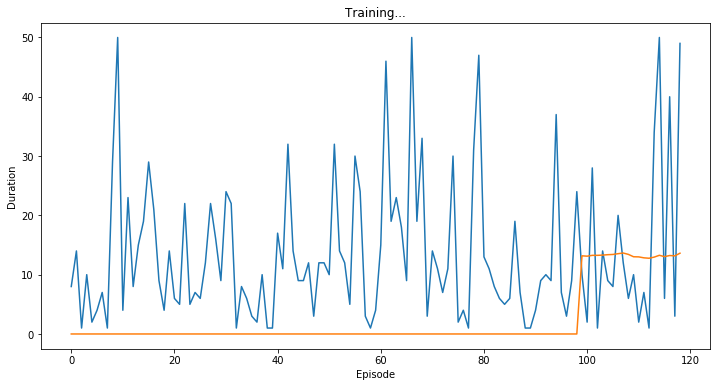

[time_step:0]  initialised backbone parameters & optimizer
[time_step:0]  initialised phi value: started ...



[time_step:0]  initialised phi value: done
[time_step:0]  added observation
[time_step:0]  environment initialised : AutoTrainEnvironment with the following parameters:
                        lr_init=0.0003, inter_reward=1, 
                        H=3, K=7, T=375
[ATA] exploration policy enacted
[time_step:0]  action [0] recieved
[time_step:0]  decreased lr by 10% -> [lr:0.00027]
[time_step:0]  training loop started ...
[time_step:1]  training loop done!



[time_step:1]  added observation
[time_step:1]  reward at the end of time step is [1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [8.0] seconds for one full step
[ATA] state dimensions:  torch.Size([1, 27])
[time_step:1]  action [7] recieved
[time_step:1]  received RE-INIT signal or rewind_steps[2] > len(ll)
[time_step:1]  initialised backbone parameters & optimizer
[time_step:1]  training loop started ...


/opt/tljh/user/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[time_step:2]  training loop done!



[time_step:2]  added observation
[time_step:2]  reward at the end of time step is [1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [10.0] seconds for one full step
[ATA] state dimensions:  torch.Size([1, 27])
[time_step:2]  action [7] recieved
[time_step:2]  received RE-INIT signal or rewind_steps[2] > len(ll)
[time_step:2]  initialised backbone parameters & optimizer
[time_step:2]  training loop started ...
[time_step:3]  training loop done!



[time_step:3]  added observation
[time_step:3]  reward at the end of time step is [-1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [10.1] seconds for one full step
[ATA] state dimensions:  torch.Size([1, 27])
[time_step:3]  action [7] recieved
[time_step:3]  received RE-INIT signal or rewind_steps[2] > len(ll)
[time_step:3]  initialised backbone parameters & optimizer
[time_step:3]  training loop started ...
[time_step:4]  training loop done!



[time_step:4]  added observation
[time_step:4]  reward at the end of time step is [1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [9.8] seconds for one full step
[ATA] exploration policy enacted
[time_step:4]  action [8] recieved
[time_step:4]  received RE-INIT signal or rewind_steps[3] > len(ll)
[time_step:4]  initialised backbone parameters & optimizer
[time_step:4]  training loop started ...
[time_step:5]  training loop done!



[time_step:5]  added observation
[time_step:5]  reward at the end of time step is [1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [10.4] seconds for one full step
[ATA] state dimensions:  torch.Size([1, 27])
[time_step:5]  action [7] recieved
[time_step:5]  received RE-INIT signal or rewind_steps[2] > len(ll)
[time_step:5]  initialised backbone parameters & optimizer
[time_step:5]  training loop started ...
[time_step:6]  training loop done!



[time_step:6]  added observation
[time_step:6]  reward at the end of time step is [-1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [8.4] seconds for one full step
[ATA] state dimensions:  torch.Size([1, 27])
[time_step:6]  action [7] recieved
[time_step:6]  received RE-INIT signal or rewind_steps[2] > len(ll)
[time_step:6]  initialised backbone parameters & optimizer
[time_step:6]  training loop started ...
[time_step:7]  training loop done!



[time_step:7]  added observation
[time_step:7]  reward at the end of time step is [-1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [8.5] seconds for one full step
[ATA] state dimensions:  torch.Size([1, 27])
[time_step:7]  action [7] recieved
[time_step:7]  received RE-INIT signal or rewind_steps[2] > len(ll)
[time_step:7]  initialised backbone parameters & optimizer
[time_step:7]  training loop started ...
[time_step:8]  training loop done!



[time_step:8]  added observation
[time_step:8]  reward at the end of time step is [-1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [8.2] seconds for one full step
[ATA] state dimensions:  torch.Size([1, 27])
[time_step:8]  action [7] recieved
[time_step:8]  received RE-INIT signal or rewind_steps[2] > len(ll)
[time_step:8]  initialised backbone parameters & optimizer
[time_step:8]  training loop started ...
[time_step:9]  training loop done!



[time_step:9]  added observation
[time_step:9]  reward at the end of time step is [1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [9.0] seconds for one full step
[ATA] exploration policy enacted
[time_step:9]  action [5] recieved
[time_step:9]  training loop started ...
[time_step:10]  training loop done!



[time_step:10]  added observation
[time_step:10]  reward at the end of time step is [1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [8.7] seconds for one full step
[ATA] state dimensions:  torch.Size([1, 27])
[time_step:10]  action [7] recieved
[time_step:10]  received RE-INIT signal or rewind_steps[2] > len(ll)
[time_step:10]  initialised backbone parameters & optimizer
[time_step:10]  training loop started ...
[time_step:11]  training loop done!



[time_step:11]  added observation
[time_step:11]  reward at the end of time step is [-1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [8.2] seconds for one full step
[ATA] exploration policy enacted
[time_step:11]  action [3] recieved
[time_step:11]  decreased lr by 10% -> [lr:0.000243]
[time_step:11]  received RE-INIT signal or rewind_steps[3] > len(ll)
[time_step:11]  initialised backbone parameters & optimizer
[time_step:11]  training loop started ...
[time_step:12]  training loop done!



[time_step:12]  added observation
[time_step:12]  reward at the end of time step is [1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [8.1] seconds for one full step
[ATA] exploration policy enacted
[time_step:12]  action [0] recieved
[time_step:12]  decreased lr by 10% -> [lr:0.0002187]
[time_step:12]  training loop started ...
[time_step:13]  training loop done!



[time_step:13]  added observation
[time_step:13]  reward at the end of time step is [-1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [9.0] seconds for one full step
[ATA] exploration policy enacted
[time_step:13]  action [8] recieved
[time_step:13]  received RE-INIT signal or rewind_steps[3] > len(ll)
[time_step:13]  initialised backbone parameters & optimizer
[time_step:13]  training loop started ...
[time_step:14]  training loop done!



[time_step:14]  added observation
[time_step:14]  reward at the end of time step is [-1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [9.2] seconds for one full step
[ATA] state dimensions:  torch.Size([1, 27])
[time_step:14]  action [7] recieved
[time_step:14]  received RE-INIT signal or rewind_steps[2] > len(ll)
[time_step:14]  initialised backbone parameters & optimizer
[time_step:14]  training loop started ...
[time_step:15]  training loop done!



[time_step:15]  added observation
[time_step:15]  reward at the end of time step is [1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [9.9] seconds for one full step
[ATA] state dimensions:  torch.Size([1, 27])
[time_step:15]  action [7] recieved
[time_step:15]  received RE-INIT signal or rewind_steps[2] > len(ll)
[time_step:15]  initialised backbone parameters & optimizer
[time_step:15]  training loop started ...
[time_step:16]  training loop done!



[time_step:16]  added observation
[time_step:16]  reward at the end of time step is [1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [8.6] seconds for one full step
[ATA] state dimensions:  torch.Size([1, 27])
[time_step:16]  action [7] recieved
[time_step:16]  received RE-INIT signal or rewind_steps[2] > len(ll)
[time_step:16]  initialised backbone parameters & optimizer
[time_step:16]  training loop started ...
[time_step:17]  training loop done!



[time_step:17]  added observation
[time_step:17]  reward at the end of time step is [-1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [8.9] seconds for one full step
[ATA] exploration policy enacted
[time_step:17]  action [5] recieved
[time_step:17]  training loop started ...
[time_step:18]  training loop done!



[time_step:18]  added observation
[time_step:18]  reward at the end of time step is [1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [8.1] seconds for one full step
[ATA] state dimensions:  torch.Size([1, 27])
[time_step:18]  action [7] recieved
[time_step:18]  received RE-INIT signal or rewind_steps[2] > len(ll)
[time_step:18]  initialised backbone parameters & optimizer
[time_step:18]  training loop started ...
[time_step:19]  training loop done!



[time_step:19]  added observation
[time_step:19]  reward at the end of time step is [-1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [8.0] seconds for one full step
[ATA] state dimensions:  torch.Size([1, 27])
[time_step:19]  action [7] recieved
[time_step:19]  received RE-INIT signal or rewind_steps[2] > len(ll)
[time_step:19]  initialised backbone parameters & optimizer
[time_step:19]  training loop started ...
[time_step:20]  training loop done!



[time_step:20]  added observation
[time_step:20]  reward at the end of time step is [-1]
[ATA] batch shapes: [torch.Size([16, 27]) torch.Size([16, 1]) torch.Size([16])]
[ATA] DQN optimisation step complete 
[ATA episode 119]: took [8.3] seconds for one full step
[ATA] state dimensions:  torch.Size([1, 27])
[time_step:20]  action [7] recieved
[time_step:20]  received RE-INIT signal or rewind_steps[2] > len(ll)
[time_step:20]  initialised backbone parameters & optimizer
[time_step:20]  training loop started ...
[time_step:21]  training loop done!


In [ ]:
# Train an agent

agent = AutoTrainAgent(env, DEVICE)

num_episodes = 300
for i_episode in range(num_episodes):
    t = agent.episode(i_episode)
    episode_durations.append(t + 1)
    plot_durations()

display.clear_output(wait=True)
print('Complete')
cpenv.env.render()
cpenv.env.close()
plt.ioff()

In [ ]:
env.logmdp

In [ ]:
env.observation_space_dim